# UK Music Charts Artists

## Initialisation

In [158]:
library(tidyverse)

# Use read_tsv because some lines have commas in them which aren't escaped, and so fields are separated with tabs
artists <- read_tsv('artists_dedupe.txt', col_names = c("name"), col_types = "__c", , trim_ws = TRUE)

## Calculate statistics

### Artists whose name is of the form "X and the Y"

In [159]:
# We need the space before and after to make sure we don't match e.g. SAND.  Also, we need at least one bit of word
# before and after - " AND THE Y" and "X AND THE " don't count.  It has to be "X AND THE Y".
xAndTheYpattern <- "[\\S]+ (AND|&) THE [\\S]+"

xAndTheYartists <- str_subset(artists$name, xAndTheYpattern)

### Football and rugby teams

In [160]:
# This won't catch interesting names that don't include FC etc, such as Hamilton Academicals or Sheffield Wednesday
footballPattern <- " (F\\.C\\.|FC|AFC|A\\.F\\.C\\.|RFC|R\\.F\\.C\\.|FA|F\\.A\\.|FOOTBALL|RUGBY|RANGERS|TEAM|SQUAD|UNITED) |ENGLANDNEWORDER"

# Need this because the main pattern also brings artists that aren't football or rugby teams as far as I'm aware
exceptionsPattern <- "APARTHEID|BELLY|DREEM|TERROR"

footballArtistsWithExtras <- str_subset(artists$name, footballPattern)

# the version of tidyverse / stringr I'm using is too old to have negate as an option to str_subset, so fall back
# on a harder-to-use function that does the job
footballArtists <- stringi::stri_subset_regex(footballArtistsWithExtras, exceptionsPattern, negate = TRUE)

### Artists with single word names

In [161]:
# This matches x-y, e.g. DEEE-LITE, which doesn't seem properly to be one word to me
# oneWordPattern <- "^\\S+$"

# Allow random punctuation at the end of the word, to match e.g. Delirious?, and apostrophes anywhere.
oneWordPattern <- "^[0-9A-Z']+\\S$"

oneWordArtists <- str_subset(artists$name, oneWordPattern)

### Artists with a number in their name, including as a word

In [162]:
# We need Roman numerals for people like Soul II Soul.
# I left out I and V and numbeers beyond 10 as Roman numerals because they're too likely to be meant as letters and not as numbers
# If the number is a Roman numeral or a word, make sure there is a space, hyphen or start or end of line at the beginning and
# end of the match, to stop e.g. 'ONE' matching 'STONE'.
containsNumberPattern <- "[0-9]|(([ \\-^])(ONE|TWO|THREE|FOUR|FIVE|SIX|SEVEN|EIGHT|NINE|TEN|ELEVEN|TWELVE|(THIR|FOUR|FIF|SIX|SEVEN|EIGH|NINE)TEEN|(TWEN|THIR|FOR|FIF|SIX|SEVEN|EIGH|NINE)TY|HUNDRED|THOUSAND|(M|B|TR)ILLION|II|III||IV|VI|VII|VIII|IX|X)([ \\-$]]))"

numberArtists <- str_subset(artists$name, containsNumberPattern)

### Artists who do and don't collaborate with other artists

In [163]:
# Unfortunately the main pattern will split AC/DC and numbers with thousands separators.
# So treat those as an exception separately rather than making the main regex even more complicated.
# / appears to be used as a separator for artists, without spaces either side (unlike the other separators).
# This relies on the name containing some clue that its words are separate things joined together.
# E.g. "Crosby Stills Nash and Young" doesn't have commas, so looks like "Crosby Stills Nash" + "Young".

manyArtistsPattern <-  "[/,]|( (WITH|FT\\.?|FEAT\\.?|FEATURING|AND|&|VERSUS|VS\\.?) )"
exceptionsPattern <- "^AC/DC$|\\d,\\d{3}"

# this will filter out too many, so find the ones filtered out in error then add them together for the proper answer
singleArtistsWithoutExceptions <- stringi::stri_subset_regex(artists$name, manyArtistsPattern, negate = TRUE)
singleArtistsExceptions <- stringi::stri_subset_regex(artists$name, exceptionsPattern)
singleArtists <- c(singleArtistsExceptions, singleArtistsWithoutExceptions)

# this won't filter out enough, so also filter out the exceptions afterwards
jointArtistsBeforeExceptionsProcessed <-stringi::stri_subset_regex(artists$name, manyArtistsPattern)
jointArtists <- stringi::stri_subset_regex(jointArtistsBeforeExceptionsProcessed, exceptionsPattern, negate = TRUE)

# split the artists who are collaborations of 2+ artists into their components, then pool them across all entries into
# one de-duplicated list of artists who collaborate with at least one other artist
jointArtistsSplit <- strsplit(jointArtists, manyArtistsPattern)
artistsWhoCollaborate <- sort(unique(trimws(unlist(jointArtistsSplit))))

artistsWhoSometimesCollaborateAndSometimesDont <- intersect(singleArtists, artistsWhoCollaborate)
artistsWhoOnlyCollaborate <- setdiff(artistsWhoCollaborate, singleArtists)
artistsWhoNeverCollaborate <- setdiff(singleArtists, artistsWhoCollaborate)

## Display results

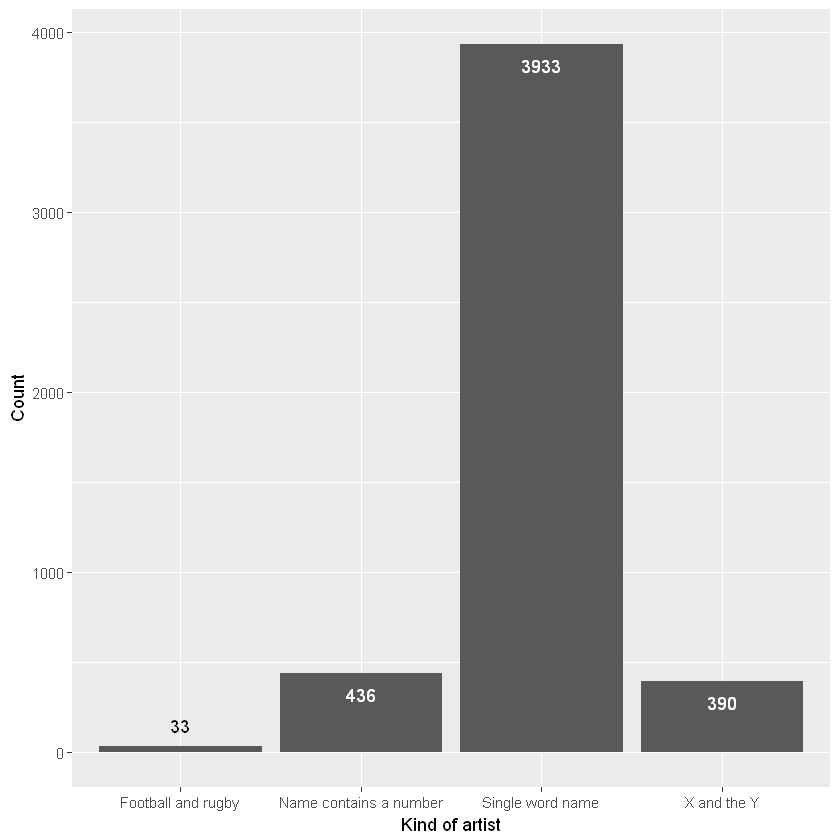

In [164]:
misc <- tibble(`Kind of artist` = c('X and the Y', 'Football and rugby', 'Single word name', 'Name contains a number'),
              Count = c(length(xAndTheYartists), length(footballArtists), length(oneWordArtists), length(numberArtists)))

# if the bars are too short to contain the text of the label (in white), put the label above the bar in black
barThreshold <- 100
misc <- mutate(misc,
       labelPosition = ifelse(Count > barThreshold, 2, -1),
       labelTextColour = ifelse(Count > barThreshold, "white", "black"))

# without scale_colour_identity, ggplot interprets the colour name as an arbitrary categorical variable and picks
# its own colour for each value, rather than interpreting the value as a colour verbatim.
ggplot(data=misc, aes(x=`Kind of artist`, y=Count)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label=Count, vjust=labelPosition, colour=labelTextColour)) +
    scale_colour_identity()


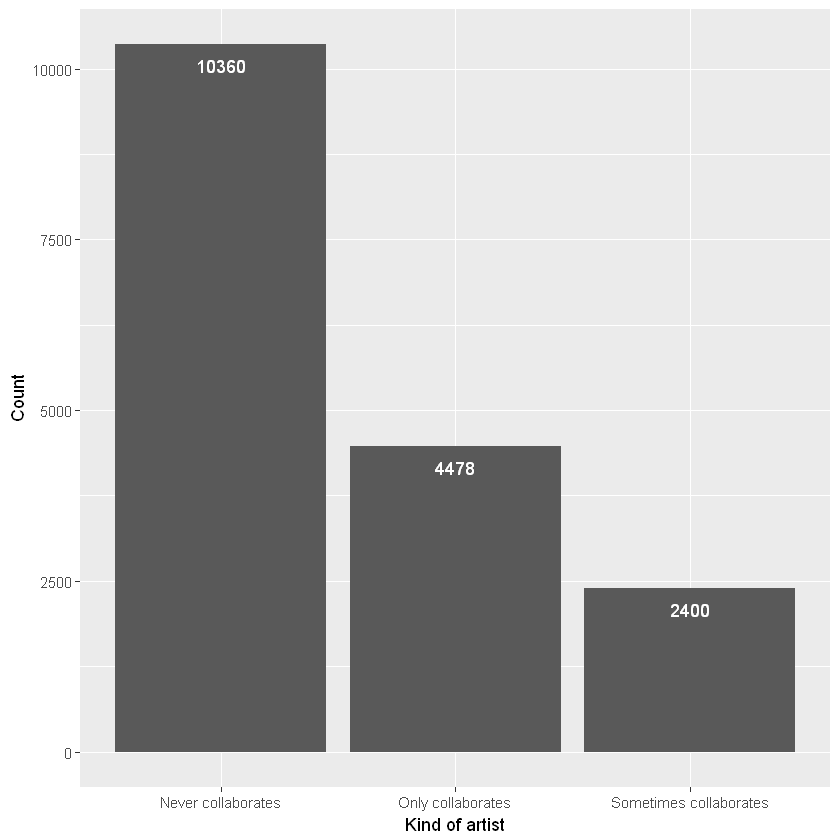

In [165]:
collaboration <- tibble(`Kind of artist` = c('Only collaborates', 'Sometimes collaborates', 'Never collaborates'),
                        Count = c(length(artistsWhoOnlyCollaborate), length(artistsWhoSometimesCollaborateAndSometimesDont),
                         length(artistsWhoNeverCollaborate)))

ggplot(collaboration, aes(`Kind of artist`, Count)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label=Count), position=position_dodge(width=0.9), vjust=2, colour="white")